## 1. Configuration

Set the paths and flags for the modeling process below. 
- `TRAIN_NEW_MODELS`: Set to `True` to run training and tuning. Set to `False` to load existing models.
- `INPUT_DIR`: The directory where your source data CSV is located.
- `DATAFRAME_NAME`: The name of your CSV file (without the `.csv` extension).
- `OUTPUT_DIR_WINDOWS`: The root folder on your Windows drive where model pipelines will be saved. The path is written in WSL format (e.g., `/mnt/d/` for the `D:` drive).

In [13]:
import os

# Set to True to run the full training and tuning process.
# Set to False to load pre-existing models from the output directory.
TRAIN_NEW_MODELS = True

# PATHS
INPUT_DIR = os.path.join('..', '..', 'data', 'upsampled')
DATAFRAME_NAME = 'mean_df' # Name of the .csv file without the extension

# Output directory for saving model pipelines (WSL format for Windows D: drive)
# This path corresponds to D:\ML_Pipelines in Windows
OUTPUT_ROOT_DIR_WINDOWS = '/mnt/d/EMEWS_ML_Pipelines_Output/best_features_regression'
DATAFRAME_SPECIFIC_PATH = os.path.join(OUTPUT_ROOT_DIR_WINDOWS, DATAFRAME_NAME)
BASE_MODEL_PATH = os.path.join(DATAFRAME_SPECIFIC_PATH, 'base_models')
TUNED_MODEL_PATH = os.path.join(DATAFRAME_SPECIFIC_PATH, 'tuned_models')

# Create directories if they don't exist
if TRAIN_NEW_MODELS:
    print(f"Creating directory for base models: {BASE_MODEL_PATH}")
    os.makedirs(BASE_MODEL_PATH, exist_ok=True)
    print(f"Creating directory for tuned models: {TUNED_MODEL_PATH}")
    os.makedirs(TUNED_MODEL_PATH, exist_ok=True)
else:
    print("TRAIN_NEW_MODELS is False. Will attempt to load existing models.")

Creating directory for base models: /mnt/d/EMEWS_ML_Pipelines_Output/best_features_regression/mean_df/base_models
Creating directory for tuned models: /mnt/d/EMEWS_ML_Pipelines_Output/best_features_regression/mean_df/tuned_models


## 2. Setup and Data Loading

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from pycaret.regression import *

In [15]:
df = pd.read_csv(os.path.join(INPUT_DIR, f'{DATAFRAME_NAME}.csv'))
df['date'] = pd.to_datetime(df['date'])

## Evaluate min number of best features

In [16]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

X = df.drop(columns=['total_number_of_patients'])

X['month'] = X['date'].dt.month
X['day'] = X['date'].dt.day
X['weekday'] = X['date'].dt.weekday
X['weekofyear'] = X['date'].dt.isocalendar().week.astype(int)
X['dayofyear'] = X['date'].dt.dayofyear
X['is_weekend'] = X['weekday'] >= 5 

X = X.drop(columns=['date'])

y = df['total_number_of_patients']

max_k = X.shape[1]
k_values = range(1, max_k + 1)

results = []

# Loop through different values of k
for k in k_values:
    selector = SelectKBest(score_func=mutual_info_regression, k=k)
    X_new = selector.fit_transform(X, y)

    # Initialize model
    model = LinearRegression()

    # Evaluate using cross-validated R²
    scores = cross_val_score(model, X_new, y, cv=5, scoring='neg_root_mean_squared_error')
    mean_rmse = -np.mean(scores)
    
    # results.append((k, mean_rmse))

    results.append({
        'k': k,
        'Mean_RMSE': mean_rmse
    })

In [17]:
results_df = pd.DataFrame(results)

best_result = results_df.loc[results_df['Mean_RMSE'].idxmin()]
best_k = int(best_result['k'])
min_rmse = best_result['Mean_RMSE']

In [18]:
final_selector = SelectKBest(score_func=mutual_info_regression, k=best_k)
final_selector.fit(X, y)
selected_features = X.columns[final_selector.get_support()]

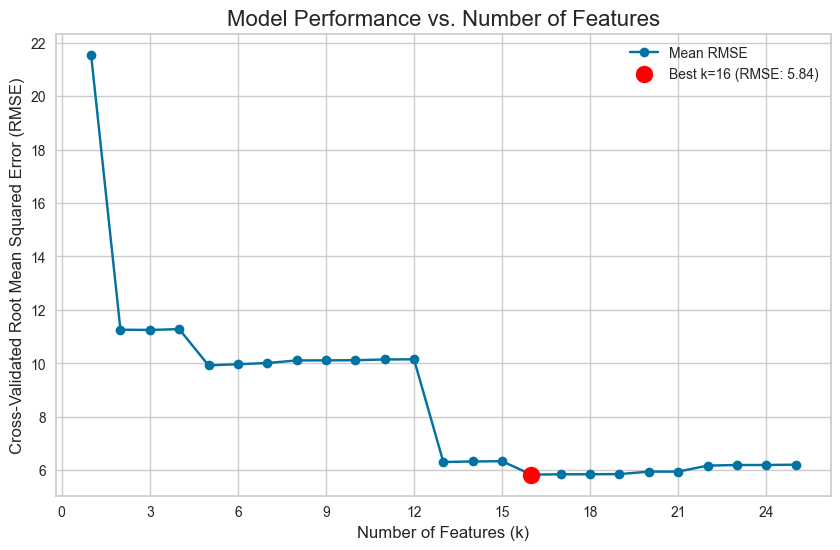

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the RMSE for each k
ax.plot(results_df['k'], results_df['Mean_RMSE'], marker='o', linestyle='-', label='Mean RMSE')

# Highlight the best k
ax.scatter(best_k, min_rmse, color='red', s=150, zorder=5, label=f'Best k={best_k} (RMSE: {min_rmse:.2f})')

ax.set_title('Model Performance vs. Number of Features', fontsize=16)
ax.set_xlabel('Number of Features (k)', fontsize=12)
ax.set_ylabel('Cross-Validated Root Mean Squared Error (RMSE)', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True)

# Set integer ticks on x-axis
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
# Set integer ticks on y-axis
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Save the figure as PNG
plt.savefig('model_performance.png', dpi=300, bbox_inches='tight')

plt.show()


## 3. Pycaret Setup

In [20]:
list(selected_features)

['zone_a_mwr_patients',
 'zone_a_mwr_cat_3',
 'zone_a_mwr_cat_4',
 'zone_a_mwr_sets_of_emews',
 'zone_a_mwr_deescalations',
 'zone_a_mwr_escalations',
 'zone_a__patients',
 'zone_a__cat_2',
 'zone_a__sets_of_emews',
 'zone_b/c_patients',
 'zone_b/c_cat_3',
 'zone_b/c_sets_of_emews',
 'total_number_of_emews',
 'month',
 'weekofyear',
 'dayofyear']

In [21]:
df['month'] = df['date'].dt.month
df['weekofyear'] = df['date'].dt.isocalendar().week.astype(int)
df['dayofyear'] = df['date'].dt.dayofyear

df = df[list(selected_features) + ['total_number_of_patients']]

fh = 60
split_point = df.shape[0] - fh

train_data = df.iloc[:split_point]
test_data = df.iloc[split_point:]

In [22]:
setup(
    data=train_data,
    target='total_number_of_patients',
    test_data=test_data,
    fold_strategy='timeseries',
    data_split_shuffle=False,
    fold_shuffle=False,
    session_id=123
    );

,Description,Value
0,Session id,123
1,Target,total_number_of_patients
2,Target type,Regression
3,Original data shape,"(618, 17)"
4,Transformed data shape,"(618, 17)"
5,Transformed train set shape,"(558, 17)"
6,Transformed test set shape,"(60, 17)"
7,Numeric features,16
8,Preprocess,True
9,Imputation type,simple


In [23]:
models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


## 4. Model Training or Loading

Based on the `TRAIN_NEW_MODELS` flag, this section will either train and save new models or load existing ones.

In [24]:
created_models = {}
tuned_models = {}

if TRAIN_NEW_MODELS:
    print("Starting Model Training and Tuning")
    
    # Step 1: Compare base models
    compare_models(exclude=['lightgbm', 'par', 'dummy', 'lar'], errors='raise')
    best_models_df = pull()
    model_names_to_process = best_models_df.index[:5].tolist()

    # Step 2: Create, save, and tune base models
    for model_name in model_names_to_process:
        print(f'\n--- Processing Model: {model_name} ---')
        
        # Create base model
        print(f'Creating base model: {model_name}')
        base_model = create_model(model_name, verbose=False)
        created_models[model_name] = base_model
        
        # Save base model pipeline
        save_path_base = os.path.join(BASE_MODEL_PATH, model_name)
        print(f'Saving base model to: {save_path_base}')
        save_model(base_model, save_path_base)
        
        # Tune model
        print(f'Tuning model: {model_name}')
        tuned_model = tune_model(
            base_model,
            search_library='scikit-optimize',
            n_iter=20,
            early_stopping=True,
            verbose=False
        )
        tuned_models[model_name] = tuned_model
        
        # Save tuned model pipeline
        save_path_tuned = os.path.join(TUNED_MODEL_PATH, model_name)
        print(f'Saving tuned model to: {save_path_tuned}')
        save_model(tuned_model, save_path_tuned)

else:
    print("--- Loading Existing Models ---")
    # Load base and tuned models if they exist
    if os.path.exists(BASE_MODEL_PATH):
        model_names_to_process = [os.path.splitext(f)[0] for f in os.listdir(BASE_MODEL_PATH) if f.endswith('.pkl')]
        print(f"Found models in {BASE_MODEL_PATH}: {model_names_to_process}")
    else:
        print(f"ERROR: Base model directory not found at {BASE_MODEL_PATH}. Cannot load models.")
        model_names_to_process = []
    
    for name in model_names_to_process:
        base_path = os.path.join(BASE_MODEL_PATH, name)
        tuned_path = os.path.join(TUNED_MODEL_PATH, name)
        
        # Load Base Model
        if os.path.exists(f'{base_path}.pkl'):
            print(f'Loading base model: {name} from {base_path}')
            created_models[name] = load_model(base_path, verbose=False)
        else:
            print(f'WARNING: Base model for {name} not found at {base_path}.pkl')
            
        # Load Tuned Model
        if os.path.exists(f'{tuned_path}.pkl'):
            print(f'Loading tuned model: {name} from {tuned_path}')
            tuned_models[name] = load_model(tuned_path, verbose=False)
        else:
            print(f'WARNING: Tuned model for {name} not found at {tuned_path}.pkl')

print("\nModel processing complete.")
print(f"\nBase models available: {list(created_models.keys())}")
print(f"Tuned models available: {list(tuned_models.keys())}")

Starting Model Training and Tuning


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,2.8676,29.5208,5.0607,0.9211,0.2108,0.0982,0.0100
br,Bayesian Ridge,4.3680,42.7437,6.2349,0.8874,0.2304,0.1508,0.0080
en,Elastic Net,4.3924,42.9999,6.2366,0.8863,0.2291,0.1526,0.0100
lasso,Lasso Regression,4.4044,43.2196,6.2494,0.8857,0.2296,0.1542,0.1500
llar,Lasso Least Angle Regression,4.4047,43.2238,6.2496,0.8857,0.2296,0.1542,0.0080
et,Extra Trees Regressor,4.1217,51.5292,6.4922,0.8733,0.1561,0.1073,0.0330
ridge,Ridge Regression,4.8548,49.6832,6.5991,0.8708,0.2252,0.1523,0.0080
catboost,CatBoost Regressor,4.4523,58.2342,6.6255,0.8579,0.1623,0.1225,0.4800
gbr,Gradient Boosting Regressor,4.8151,60.2250,7.1186,0.8472,0.1899,0.1444,0.0230
lr,Linear Regression,5.4026,68.1501,7.2334,0.8257,0.2378,0.1585,0.3260



--- Processing Model: huber ---
Creating base model: huber
Saving base model to: /mnt/d/EMEWS_ML_Pipelines_Output/best_features_regression/mean_df/base_models/huber
Transformation Pipeline and Model Successfully Saved
Tuning model: huber
Saving tuned model to: /mnt/d/EMEWS_ML_Pipelines_Output/best_features_regression/mean_df/tuned_models/huber
Transformation Pipeline and Model Successfully Saved

--- Processing Model: br ---
Creating base model: br
Saving base model to: /mnt/d/EMEWS_ML_Pipelines_Output/best_features_regression/mean_df/base_models/br
Transformation Pipeline and Model Successfully Saved
Tuning model: br
Saving tuned model to: /mnt/d/EMEWS_ML_Pipelines_Output/best_features_regression/mean_df/tuned_models/br
Transformation Pipeline and Model Successfully Saved

--- Processing Model: en ---
Creating base model: en
Saving base model to: /mnt/d/EMEWS_ML_Pipelines_Output/best_features_regression/mean_df/base_models/en
Transformation Pipeline and Model Successfully Saved
Tunin

## 5. Evaluate and Analyze Models

This section provides detailed plots and metrics for each of the models (either newly trained or loaded).

### Bayesian Ridge

In [25]:
if 'br' in created_models:
    print("--- Base Bayesian Ridge ---")
    evaluate_model(created_models['br'])
if 'br' in tuned_models:
    print("--- Tuned Bayesian Ridge ---")
    evaluate_model(tuned_models['br'])

--- Base Bayesian Ridge ---


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

--- Tuned Bayesian Ridge ---


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

### Lasso Regression

In [26]:
if 'lasso' in created_models:
    print("--- Base Lasso Regression ---")
    evaluate_model(created_models['lasso'])
# if 'lasso' in tuned_models:
#     print("--- Tuned Lasso Regression ---")
#     evaluate_model(tuned_models['lasso'])

--- Base Lasso Regression ---


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

### Lasso Least Angle Regression

In [27]:
if 'llar' in created_models:
    print("--- Base Lasso Least Angle Regression ---")
    evaluate_model(created_models['llar'])
if 'llar' in tuned_models:
    print("--- Tuned Lasso Least Angle Regression ---")
    evaluate_model(tuned_models['llar'])

--- Base Lasso Least Angle Regression ---


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

--- Tuned Lasso Least Angle Regression ---


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

### Elastic Net

In [28]:
if 'en' in created_models:
    print("--- Base Elastic Net ---")
    evaluate_model(created_models['en'])
if 'en' in tuned_models:
    print("--- Tuned Elastic Net ---")
    evaluate_model(tuned_models['en'])

--- Base Elastic Net ---


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

--- Tuned Elastic Net ---


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

### Huber Regressor

In [29]:
if 'huber' in created_models:
    print("--- Base Huber Regressor ---")
    evaluate_model(created_models['huber'])
if 'huber' in tuned_models:
    print("--- Tuned Huber Regressor ---")
    evaluate_model(tuned_models['huber'])

--- Base Huber Regressor ---


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

--- Tuned Huber Regressor ---


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

## 6. Custom Metrics and Final Predictions
This section defines and adds custom metrics for evaluating predictions on the hold-out set, then generates and saves the final performance metrics to an Excel file.

In [30]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def r2_rounded(y_true, y_pred):
    """Calculates R2 score after rounding predictions to the nearest whole number."""
    return r2_score(y_true, np.round(y_pred))

def rmse_rounded(y_true, y_pred):
    """Calculates RMSE after rounding predictions to the nearest whole number."""
    return np.sqrt(mean_squared_error(y_true, np.round(y_pred)))

def r2_ceil(y_true, y_pred):
    """Calculates R2 score after ceiling predictions to the nearest whole number."""
    return r2_score(y_true, np.ceil(y_pred))

def rmse_ceil(y_true, y_pred):
    """Calculates RMSE after ceiling predictions to the nearest whole number."""
    return np.sqrt(mean_squared_error(y_true, np.ceil(y_pred)))

def mae_rounded(y_true, y_pred):
    """Calculates MAE after rounding predictions to the nearest whole number."""
    return mean_absolute_error(y_true, np.round(y_pred))

def mae_ceil(y_true, y_pred):
    """Calculates MAE after ceiling predictions to the nearest whole number."""
    return mean_absolute_error(y_true, np.ceil(y_pred))

In [31]:
try:
    add_metric('R2_Rounded', 'R2_RND', r2_rounded, greater_is_better=True)
    add_metric('RMSE_Rounded', 'RMSE_RND', rmse_rounded, greater_is_better=False)
    add_metric('MAE_Rounded', 'MAE_RND', mae_rounded, greater_is_better=False)
    add_metric('R2_Ceil', 'R2_CEIL', r2_ceil, greater_is_better=True)
    add_metric('RMSE_Ceil', 'RMSE_CEIL', rmse_ceil, greater_is_better=False)
    add_metric('MAE_Ceil', 'MAE_CEIL', mae_ceil, greater_is_better=False)
except ValueError:
    print("Metrics may have already been added in this session.")

In [32]:
# Generate predictions for base models
holdout_predictions_metric = {}
if not created_models:
    print("No base models available to make predictions.")
else:
    for model_name, model_object in created_models.items():
        print(f"Generating predictions for base model: {model_name}")
        predict_model(model_object, verbose=False)
        holdout_predictions_metric[model_name] = pull()

# Generate predictions for tuned models
tuning_predictions_metric = {}
if not tuned_models:
    print("No tuned models available to make predictions.")
else:
    for model_name, model_object in tuned_models.items():
        print(f"Generating predictions for tuned model: {model_name}")
        predict_model(model_object, verbose=False)
        tuning_predictions_metric[model_name] = pull()

Generating predictions for base model: huber
Generating predictions for base model: br
Generating predictions for base model: en
Generating predictions for base model: lasso
Generating predictions for base model: llar
Generating predictions for tuned model: huber
Generating predictions for tuned model: br
Generating predictions for tuned model: en
Generating predictions for tuned model: lasso
Generating predictions for tuned model: llar


In [33]:
output_excel_path = os.path.join(DATAFRAME_SPECIFIC_PATH, 'model_performance_metrics.xlsx')
print(f"Saving performance metrics to: {output_excel_path}")

with pd.ExcelWriter(output_excel_path) as writer:
    # --- Process and Save Base Model Metrics ---
    if holdout_predictions_metric:
        list_of_metric_dfs_base = []
        for model_name, metrics_df in holdout_predictions_metric.items():
            list_of_metric_dfs_base.append(metrics_df)
        
        results_df_base = pd.concat(list_of_metric_dfs_base, ignore_index=True).sort_values('R2', ascending=False)
        print("\n--- Base Model Holdout Predictions ---")
        print(results_df_base.to_string())
        results_df_base.to_excel(writer, sheet_name='Base Model Metrics', index=False)
    else:
        print("\nNo base model metrics to save.")

    # --- Process and Save Tuned Model Metrics ---
    if tuning_predictions_metric:
        list_of_metric_dfs_tuned = []
        for model_name, metrics_df in tuning_predictions_metric.items():
            list_of_metric_dfs_tuned.append(metrics_df)
            
        results_df_tuned = pd.concat(list_of_metric_dfs_tuned, ignore_index=True).sort_values('R2', ascending=False)
        print("\n--- Tuned Model Holdout Predictions ---")
        print(results_df_tuned.to_string())
        results_df_tuned.to_excel(writer, sheet_name='Tuned Model Metrics', index=False)
    else:
        print("\nNo tuned model metrics to save.")

Saving performance metrics to: /mnt/d/EMEWS_ML_Pipelines_Output/best_features_regression/mean_df/model_performance_metrics.xlsx

--- Base Model Holdout Predictions ---
                          Model     MAE      MSE    RMSE      R2   RMSLE    MAPE  R2_RND  RMSE_RND  MAE_RND  R2_CEIL  RMSE_CEIL  MAE_CEIL
1                Bayesian Ridge  3.2684  19.9213  4.4633  0.9522  0.1074  0.0677  0.9537    4.3951   3.1833   0.9505     4.5442    3.2500
2                   Elastic Net  3.5822  22.6053  4.7545  0.9458  0.1100  0.0727  0.9461    4.7399   3.5667   0.9442     4.8270    3.5333
3              Lasso Regression  3.6808  23.9524  4.8941  0.9426  0.1118  0.0744  0.9421    4.9160   3.7000   0.9422     4.9092    3.5667
4  Lasso Least Angle Regression  3.6819  23.9627  4.8952  0.9426  0.1118  0.0744  0.9421    4.9160   3.7000   0.9422     4.9092    3.5667
0               Huber Regressor  3.2991  37.5805  6.1303  0.9099  0.1137  0.0520  0.9086    6.1766   3.3167   0.9050     6.2968    3.3500

---

## 7. Final Model Check

As a final step, let's examine the best performing tuned model and its predictions on the test set.

In [34]:
# Example: Check the tuned Bayesian Ridge model
best_model_name = 'br'

if best_model_name in tuned_models:
    print(f"--- Final Check of Tuned Model: {best_model_name} ---")
    predict_model(tuned_models[best_model_name], verbose=True, data=test_data)
    final_metrics = pull()
    print("\nPerformance on Test Data:")
    display(final_metrics)
else:
    print(f"Model '{best_model_name}' not found in the tuned_models dictionary.")

--- Final Check of Tuned Model: br ---


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,R2_RND,RMSE_RND,MAE_RND,R2_CEIL,RMSE_CEIL,MAE_CEIL
0,Bayesian Ridge,3.2322,19.6183,4.4293,0.9530,0.1070,0.0669,0.9533,4.4159,3.1667,0.9527,4.4441,3.1833



Performance on Test Data:


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,R2_RND,RMSE_RND,MAE_RND,R2_CEIL,RMSE_CEIL,MAE_CEIL
0,Bayesian Ridge,3.2322,19.6183,4.4293,0.953,0.107,0.0669,0.9533,4.4159,3.1667,0.9527,4.4441,3.1833
